In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# === Config ===
DATA_PATH = Path(r"/Users/uttsavkotecha/Desktop/Project Code/fda_maude_anomaly_ready.csv")

COLMAP = {
    "foi_text": "foi_text",
    "event_type": "event_type",
    "brand_name": "brand_name",
    "manufacturer_name": "manufacturer_d_name",
    "date_received": "date_received",
    "device_name": "generic_name",
    "device_class": "device_report_product_code",
    "product_problem_flag": "product_problem_flag",
    "adverse_event_flag": "adverse_event_flag",
}

# === Load CSV ===
try:
    df = pd.read_csv(DATA_PATH, low_memory=False)
except UnicodeDecodeError:
    df = pd.read_csv(DATA_PATH, low_memory=False, encoding="latin-1")

# === Parse date_received ===
df[COLMAP["date_received"]] = pd.to_datetime(df[COLMAP["date_received"]], errors="coerce")

# === FOI text cleanup ===
df[COLMAP["foi_text"]] = df[COLMAP["foi_text"]].astype(str).str.strip()
df[COLMAP["foi_text"]] = df[COLMAP["foi_text"]].replace({"": np.nan, "nan": np.nan})

# === Overview metrics ===
n_rows, n_cols = df.shape
date_min = df[COLMAP["date_received"]].min()
date_max = df[COLMAP["date_received"]].max()

text_nonnull = df[COLMAP["foi_text"]].notna().sum()
text_pct = 100 * text_nonnull / n_rows if n_rows else np.nan
text_len = df[COLMAP["foi_text"]].dropna().str.len()
len_median = text_len.median()
len_mean = text_len.mean()
len_p95 = text_len.quantile(0.95)

n_brands = df[COLMAP["brand_name"]].nunique(dropna=True)
n_manus  = df[COLMAP["manufacturer_name"]].nunique(dropna=True)

overview = pd.DataFrame({
    "Metric": [
        "Total rows",
        "Total columns",
        "Date coverage (min)",
        "Date coverage (max)",
        "FOI text present (count)",
        "FOI text present (%)",
        "FOI text length (median chars)",
        "FOI text length (mean chars)",
        "FOI text length (95th pct chars)",
        "Unique brand_name",
        "Unique manufacturer_name",
    ],
    "Value": [
        n_rows,
        n_cols,
        date_min,
        date_max,
        text_nonnull,
        round(text_pct, 2),
        int(len_median),
        round(len_mean, 1),
        int(len_p95),
        n_brands,
        n_manus,
    ]
})

print("\n=== DATASET AT A GLANCE ===")
print(overview.to_string(index=False))



=== DATASET AT A GLANCE ===
                          Metric               Value
                      Total rows              462682
                   Total columns                  50
             Date coverage (min) 2019-01-02 00:00:00
             Date coverage (max) 2024-12-20 00:00:00
        FOI text present (count)              462682
            FOI text present (%)               100.0
  FOI text length (median chars)                 224
    FOI text length (mean chars)               220.3
FOI text length (95th pct chars)                 573
               Unique brand_name                 236
        Unique manufacturer_name                  28


In [15]:
df.columns

Index(['mdr_report_key', 'device_sequence_no', 'date_received', 'brand_name',
       'generic_name', 'manufacturer_d_name', 'manufacturer_d_address_1',
       'manufacturer_d_city', 'manufacturer_d_state_code',
       'manufacturer_d_country_code', 'device_operator',
       'expiration_date_of_device', 'model_number', 'catalog_number',
       'device_availability', 'date_returned_to_manufacturer',
       'device_report_product_code', 'device_age_text',
       'device_evaluated_by_manufactur', 'combination_product_flag',
       'patient_sequence_number', 'foi_text', 'report_number',
       'report_source_code', 'adverse_event_flag', 'product_problem_flag',
       'date_of_event', 'initial_report_to_fda', 'report_to_fda',
       'event_location', 'date_manufacturer_received',
       'device_date_of_manufacture', 'single_use_flag', 'event_type',
       'type_of_report', 'source_type', 'date_added', 'date_changed',
       'reporter_country_code', 'summary_report', 'suppl_dates_fda_received

In [2]:
# === Missingness Snapshot for Key Columns ===

KEY_COLS = [
    COLMAP["foi_text"],
    COLMAP["event_type"],
    COLMAP["brand_name"],
    COLMAP["manufacturer_name"],
    COLMAP["date_received"],
    COLMAP["device_name"],
    COLMAP["device_class"],
    COLMAP["product_problem_flag"],
    COLMAP["adverse_event_flag"]
]

missing_summary = []
for col in KEY_COLS:
    if col in df.columns:
        total_missing = df[col].isna().sum()
        pct_missing = 100 * total_missing / len(df)
        missing_summary.append({
            "Column": col,
            "Missing Count": total_missing,
            "Missing %": round(pct_missing, 2)
        })
    else:
        missing_summary.append({
            "Column": col,
            "Missing Count": "Not found in dataset",
            "Missing %": None
        })

missing_df = pd.DataFrame(missing_summary)

print("\n=== MISSINGNESS SNAPSHOT ===")
print(missing_df.to_string(index=False))



=== MISSINGNESS SNAPSHOT ===
                    Column  Missing Count  Missing %
                  foi_text              0        0.0
                event_type              0        0.0
                brand_name              0        0.0
       manufacturer_d_name              0        0.0
             date_received              0        0.0
              generic_name              0        0.0
device_report_product_code              0        0.0
      product_problem_flag              0        0.0
        adverse_event_flag              0        0.0



=== EVENT TYPE DISTRIBUTION ===
 Event Type  Count  Percentage
Malfunction 441579       95.44
     Injury  21088        4.56
      Death     14        0.00
  No Answer      1        0.00


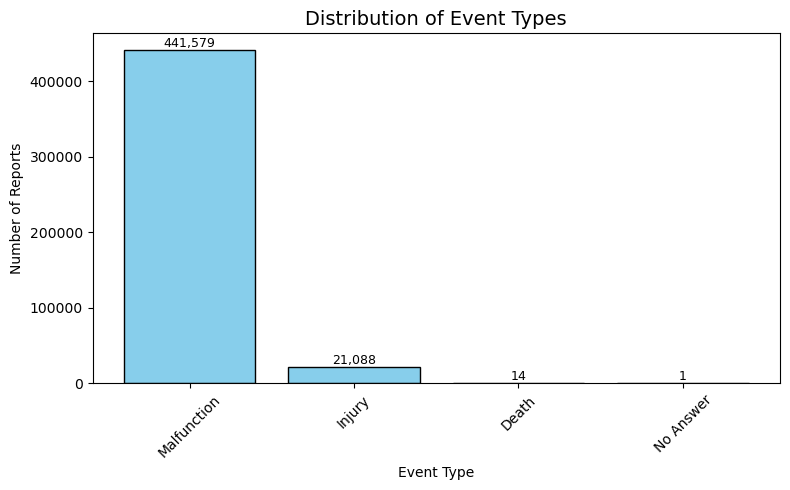

In [3]:
import matplotlib.pyplot as plt

# === Event type distribution ===
event_col = COLMAP["event_type"]

event_counts = df[event_col].value_counts().sort_values(ascending=False)
event_pct = (event_counts / len(df) * 100).round(2)

# Combine into table
event_df = pd.DataFrame({
    "Event Type": event_counts.index,
    "Count": event_counts.values,
    "Percentage": event_pct.values
})

print("\n=== EVENT TYPE DISTRIBUTION ===")
print(event_df.to_string(index=False))

# === Plot ===
plt.figure(figsize=(8, 5))
bars = plt.bar(event_counts.index, event_counts.values, color="skyblue", edgecolor="black")

# Annotate counts on bars
for bar, count in zip(bars, event_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{count:,}", 
             ha='center', va='bottom', fontsize=9)

plt.title("Distribution of Event Types", fontsize=14)
plt.xlabel("Event Type")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



=== TOP 10 BRANDS ===
                                           Brand Name  Count  Percentage
       dexcom g6 continuous glucose monitoring system 369974       79.96
                               libre sensor freestyle  22377        4.84
                             libre 2 sensor freestyle  16754        3.62
dexcom g5 mobile continuous glucose monitoring system  13512        2.92
                               freestyle libre 14 day   7908        1.71
                                    freestyle libre 2   7279        1.57
                        freestyle libre sensor 14 day   6000        1.30
                                          true metrix   2480        0.54
                                     eversense sensor   1723        0.37
                                         contour next   1403        0.30


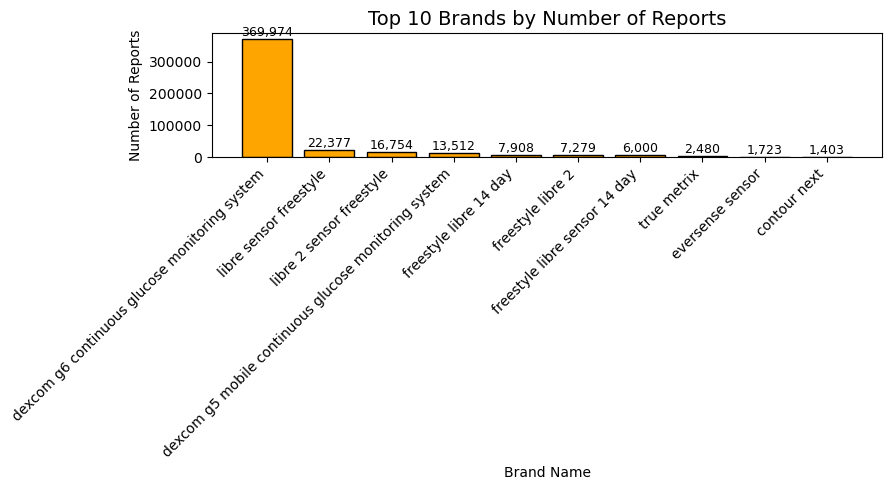

In [4]:
# === Top 10 brands ===
brand_col = COLMAP["brand_name"]

brand_counts = df[brand_col].value_counts().head(10)
brand_pct = (brand_counts / len(df) * 100).round(2)

brand_df = pd.DataFrame({
    "Brand Name": brand_counts.index,
    "Count": brand_counts.values,
    "Percentage": brand_pct.values
})

print("\n=== TOP 10 BRANDS ===")
print(brand_df.to_string(index=False))

# === Plot ===
plt.figure(figsize=(9, 5))
bars = plt.bar(brand_counts.index, brand_counts.values, color="orange", edgecolor="black")

# Annotate counts
for bar, count in zip(bars, brand_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{count:,}",
             ha='center', va='bottom', fontsize=9)

plt.title("Top 10 Brands by Number of Reports", fontsize=14)
plt.xlabel("Brand Name")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


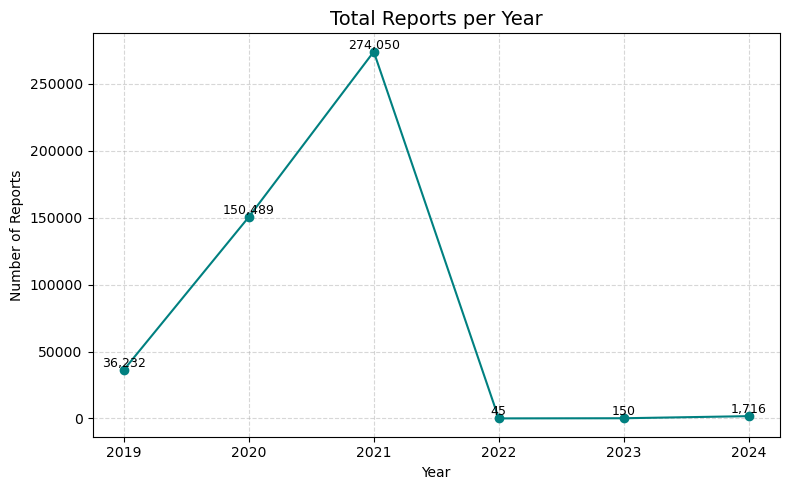

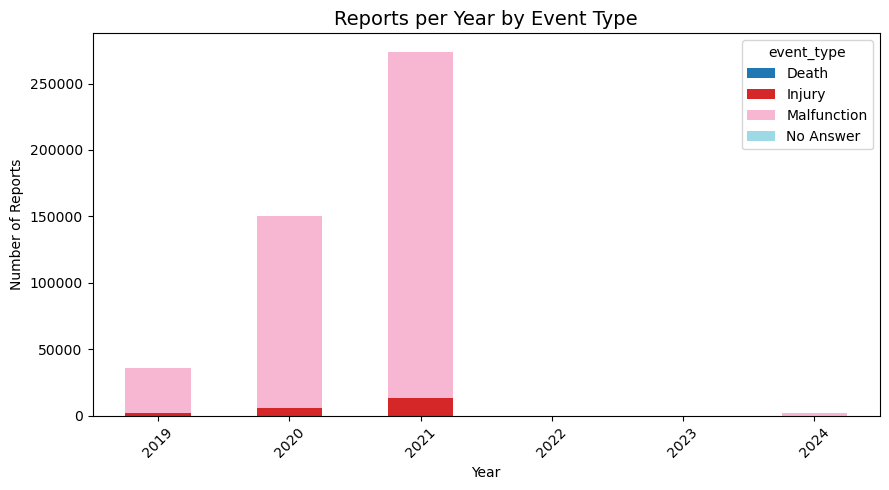

In [5]:
# === Reports per Year ===
date_col = COLMAP["date_received"]
event_col = COLMAP["event_type"]

# Extract year
df["year"] = df[date_col].dt.year

# Aggregate total reports per year
year_counts = df["year"].value_counts().sort_index()

# Simple line plot
plt.figure(figsize=(8, 5))
plt.plot(year_counts.index, year_counts.values, marker="o", color="teal")
for x, y in zip(year_counts.index, year_counts.values):
    plt.text(x, y, f"{y:,}", ha="center", va="bottom", fontsize=9)
plt.title("Total Reports per Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# === OPTIONAL: Stacked by Event Type ===
year_event = df.groupby(["year", event_col]).size().unstack(fill_value=0)

year_event.plot(kind="bar", stacked=True, figsize=(9, 5), colormap="tab20")
plt.title("Reports per Year by Event Type", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
# Columns
error_col = "reconstruction_error"
anomaly_flag_col = "ae_anomaly"

# Basic stats for reconstruction error
error_stats = df[error_col].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])
print("\n=== RECONSTRUCTION ERROR STATS ===")
print(error_stats)

# Anomaly flag counts
anomaly_counts = df[anomaly_flag_col].value_counts()
anomaly_pct = (anomaly_counts / len(df) * 100).round(2)

print("\n=== ANOMALY FLAG COUNTS ===")
for label, count in anomaly_counts.items():
    print(f"{label}: {count:,} reports ({anomaly_pct[label]}%)")



=== RECONSTRUCTION ERROR STATS ===
count    462682.000000
mean          0.000378
std           0.000961
min           0.000005
25%           0.000005
50%           0.000044
75%           0.000229
95%           0.002034
99%           0.005124
max           0.013831
Name: reconstruction_error, dtype: float64

=== ANOMALY FLAG COUNTS ===
0: 443,248 reports (95.8%)
1: 19,434 reports (4.2%)



=== TOP 10 BRANDS BY ANOMALY RATE ===
                                                    Anomaly Rate (%)  \
brand_name                                                             
freestyle lite strips 50s                                      100.0   
dexcom g6 receiver                                             100.0   
dexcom g6 pro                                                  100.0   
pump mmt1711kl 640g v410 bk sf mm                              100.0   
freestyle libre pro cgm                                        100.0   
pen needles fg                                                 100.0   
pen needle                                                     100.0   
paradigm realtime insulin infusion pump mmt722pnas             100.0   
dexcom g6 diabetic blood glucose monitor                       100.0   
dexcom g6 continuous glucose sensor                            100.0   

                                                    Anomaly Count  
brand_name                  

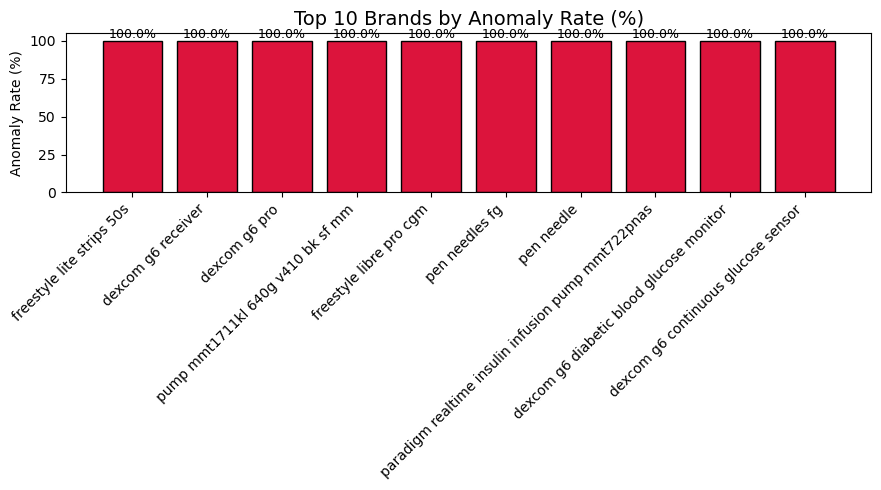

In [7]:
# === Top 10 brands by anomaly rate ===
brand_col = COLMAP["brand_name"]
anomaly_flag_col = "ae_anomaly"

brand_anomaly_rate = (
    df.groupby(brand_col)[anomaly_flag_col]
      .mean()
      .sort_values(ascending=False) * 100
).round(2)

brand_anomaly_count = (
    df.groupby(brand_col)[anomaly_flag_col]
      .sum()
      .astype(int)
)

brand_summary = pd.DataFrame({
    "Anomaly Rate (%)": brand_anomaly_rate,
    "Anomaly Count": brand_anomaly_count
}).sort_values("Anomaly Rate (%)", ascending=False).head(10)

print("\n=== TOP 10 BRANDS BY ANOMALY RATE ===")
print(brand_summary)

# === Plot ===
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
bars = plt.bar(brand_summary.index, brand_summary["Anomaly Rate (%)"], color="crimson", edgecolor="black")

# Annotate
for bar, rate in zip(bars, brand_summary["Anomaly Rate (%)"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{rate}%", 
             ha='center', va='bottom', fontsize=9)

plt.title("Top 10 Brands by Anomaly Rate (%)", fontsize=14)
plt.ylabel("Anomaly Rate (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



=== TOP 10 BRANDS BY ANOMALY RATE (≥100 REPORTS) ===
                                            Anomaly Rate (%)  Anomaly Count  \
eversense sensor                                       97.62           1682   
eversense transmitter                                  97.02            521   
minimed 770g us system ble connect 30 mgdl             95.97            262   
metrix air                                             88.14            208   
truemetrix                                             86.30            592   
true metrix                                            81.61           2024   
truetrack                                              79.74            248   
contour                                                76.54            124   
true metrix air                                        76.37            669   
contour next                                           72.70           1020   

                                            Total Reports  
eversense sensor

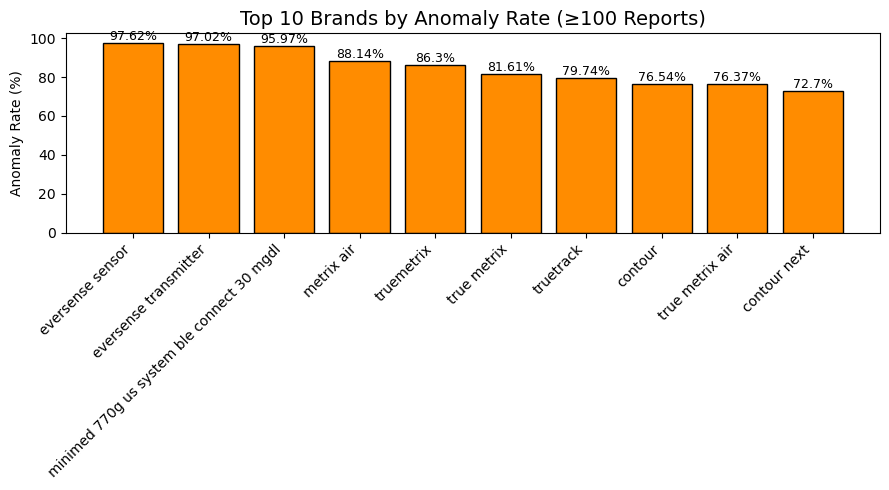

In [8]:
# === Top brands by anomaly rate (min 100 total reports) ===
brand_col = COLMAP["brand_name"]
anomaly_flag_col = "ae_anomaly"

# Total report counts per brand
brand_total_count = df[brand_col].value_counts()

# Filter brands with >=100 total reports
brands_filtered = brand_total_count[brand_total_count >= 100].index

# Compute anomaly rate and counts
brand_anomaly_rate = (
    df[df[brand_col].isin(brands_filtered)]
    .groupby(brand_col)[anomaly_flag_col]
    .mean()
    .sort_values(ascending=False) * 100
).round(2)

brand_anomaly_count = (
    df[df[brand_col].isin(brands_filtered)]
    .groupby(brand_col)[anomaly_flag_col]
    .sum()
    .astype(int)
)

brand_summary_filtered = pd.DataFrame({
    "Anomaly Rate (%)": brand_anomaly_rate,
    "Anomaly Count": brand_anomaly_count,
    "Total Reports": brand_total_count.loc[brands_filtered]
}).sort_values("Anomaly Rate (%)", ascending=False).head(10)

print("\n=== TOP 10 BRANDS BY ANOMALY RATE (≥100 REPORTS) ===")
print(brand_summary_filtered)

# === Plot ===
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
bars = plt.bar(brand_summary_filtered.index, brand_summary_filtered["Anomaly Rate (%)"], 
               color="darkorange", edgecolor="black")

# Annotate bars
for bar, rate in zip(bars, brand_summary_filtered["Anomaly Rate (%)"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{rate}%", 
             ha='center', va='bottom', fontsize=9)

plt.title("Top 10 Brands by Anomaly Rate (≥100 Reports)", fontsize=14)
plt.ylabel("Anomaly Rate (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [9]:
# === Sample anomalous FOI narratives for specific brands ===
brands_to_sample = [
    "eversense sensor",
    "minimed 770g us system ble connect 3 0 mgdl"  # match exact string from your brand column
]

text_col = COLMAP["foi_text"]
brand_col = COLMAP["brand_name"]
anomaly_flag_col = "ae_anomaly"

sampled_anomalies = {}

for brand in brands_to_sample:
    # Filter anomalies for the brand
    subset = df[(df[brand_col].str.lower() == brand.lower()) &
                (df[anomaly_flag_col] == 1)]
    
    # Random sample of up to 3 narratives
    sample_texts = subset[text_col].dropna().sample(min(3, len(subset)), random_state=42).tolist()
    
    sampled_anomalies[brand] = sample_texts

# Print results
for brand, texts in sampled_anomalies.items():
    print(f"\n=== {brand.upper()} — Sample Anomalous Narratives ===")
    for i, t in enumerate(texts, start=1):
        print(f"{i}. {t[:300]}{'...' if len(t) > 300 else ''}")



=== EVERSENSE SENSOR — Sample Anomalous Narratives ===
1. on (b)(6) 2019, the sensor experienced an early sensor retirement and failed to last the expected 90 days thereby requiring early removal of the inserted device.
2. the manufacturer is currently performing an investigation and will provide the results with the supplemental report.
3. the sensor was removed during second attempt on (b)(6) 2019.

=== MINIMED 770G US SYSTEM BLE CONNECT 3 0 MGDL — Sample Anomalous Narratives ===


In [10]:
brand_col = COLMAP["brand_name"]

# Show all unique brand names that contain 'minimed' (case-insensitive)
minimed_brands = df[brand_col].dropna().unique()
minimed_brands = [b for b in minimed_brands if "minimed" in b.lower()]

print("\n=== BRANDS CONTAINING 'MINIMED' ===")
for b in minimed_brands:
    print(b)



=== BRANDS CONTAINING 'MINIMED' ===
minimed 770g us system ble connect 30 mgdl
bomba de insulina minimed 640g


In [11]:
# === Sample anomalous FOI narratives for MiniMed 770G ===
brand_col = COLMAP["brand_name"]
text_col = COLMAP["foi_text"]
anomaly_flag_col = "ae_anomaly"

brand_name_minimed = "minimed 770g us system ble connect 30 mgdl"

subset_minimed = df[(df[brand_col].str.lower() == brand_name_minimed.lower()) &
                    (df[anomaly_flag_col] == 1)]

sample_texts_minimed = subset_minimed[text_col].dropna().sample(min(3, len(subset_minimed)), random_state=42).tolist()

print(f"\n=== {brand_name_minimed.upper()} — Sample Anomalous Narratives ===")
for i, t in enumerate(sample_texts_minimed, start=1):
    print(f"{i}. {t[:300]}{'...' if len(t) > 300 else ''}")



=== MINIMED 770G US SYSTEM BLE CONNECT 30 MGDL — Sample Anomalous Narratives ===
1. this mdr related to the puerto rico manufacturing site has been assigned a medwatch number from the medtronic minimed northridge site, per variance 5. medtronic, inc. (medtronic) is submitting this report to comply with 21 c.f.r. part 803, the medical device reporting regulation. this report is base...
2. this mdr related to the puerto rico manufacturing site has been assigned a medwatch number from the medtronic minimed northridge site, per variance 5. medtronic, inc. (medtronic) is submitting this report to comply with 21 c.f.r. part 803, the medical device reporting regulation. this report is base...
3. (b)(4). currently it is unknown whether or not the device may have caused or contributed to the event as no product has been returned. the device will be returned for analysis and further information will follow once the analysis has been completed. no conclusion can be drawn at this time.


In [12]:
import pandas as pd
import numpy as np
import re

# Columns we’ll use
cols_needed = [
    "report_number","date_received","brand_name","event_type","foi_text","top_keywords"
]
assert set(cols_needed).issubset(df.columns), "Missing one of required columns."

# Year for stratification
df["year"] = pd.to_datetime(df["date_received"], errors="coerce").dt.year

# Pick candidate brands (you can hardcode if you prefer)
# Option 1: top brands by volume
top_brands = df["brand_name"].value_counts().head(8).index.tolist()

# Option 2 (recommended): ensure variety across vendors (edit list as you like)
priority_brands = [
    "dexcom g6 continuous glucose monitoring system",
    "libre 2 sensor freestyle",
    "freestyle libre 14 day",
    "eversense sensor",
    "minimed 770g us system ble connect 30 mgdl",
]
brands_pool = [b for b in priority_brands if b in df["brand_name"].unique()]
if len(brands_pool) < 5:
    brands_pool = list(dict.fromkeys(brands_pool + top_brands))  # pad with top brands

brands_pool[:8]


['dexcom g6 continuous glucose monitoring system',
 'libre 2 sensor freestyle',
 'freestyle libre 14 day',
 'eversense sensor',
 'minimed 770g us system ble connect 30 mgdl']

In [13]:
# Very light keyword cleaner to parse your 'top_keywords' column safely
def parse_keywords(s, k=3):
    if pd.isna(s):
        return []
    # s might look like "['sensor failure', 'signal loss', 'adhesive']" or "sensor failure, signal loss"
    tokens = re.findall(r"[a-zA-Z][a-zA-Z\- ]{2,}", str(s).lower())
    # de-dup while preserving order
    seen, out = set(), []
    for t in tokens:
        t = t.strip()
        if t and t not in seen:
            seen.add(t)
            out.append(t)
        if len(out) >= k:
            break
    return out

# Fallback: pull a couple of uncommon words from the FOI text
STOP = set("""
the a an and or of in on to for with by from as at is was were be been being this that it its into over under during
""".split())

def rare_words(text, k=2):
    if pd.isna(text):
        return []
    words = re.findall(r"[a-zA-Z][a-zA-Z\-]{4,}", str(text).lower())
    # sort by length to bias toward specific terms, keep unique & not stopwords
    words = [w for w in sorted(set(words), key=len, reverse=True) if w not in STOP]
    return words[:k]

def craft_query(row):
    brand = str(row["brand_name"]).lower()
    year  = int(row["year"]) if pd.notna(row["year"]) else ""
    etype = str(row["event_type"]).lower()
    kws = parse_keywords(row.get("top_keywords", np.nan), k=2)
    if not kws:
        kws = rare_words(row.get("foi_text", ""), k=2)
    kw_part = " ".join(kws) if kws else ""
    # Build a natural query
    base = f"{brand} {etype} in {year}".strip()
    if kw_part:
        return f"{base} — {kw_part}"
    return base


In [14]:
# Target: up to 2 queries per brand, preferring different years & event types
gold_rows = []
for b in brands_pool:
    sub = df[df["brand_name"] == b].copy()
    if sub.empty:
        continue
    # Prefer variety by (year, event_type)
    groups = (
        sub.groupby(["year","event_type"], dropna=False)
           .size()
           .sort_values(ascending=False)
           .index
           .tolist()
    )
    # take up to 2 combos per brand
    taken = 0
    for (yr, et) in groups:
        cand = sub[(sub["year"]==yr) & (sub["event_type"]==et)]
        if cand.empty:
            continue
        # Pick the longest FOI text record to be very specific
        pick = cand.assign(_len=cand["foi_text"].str.len()).sort_values("_len", ascending=False).head(1)
        gold_rows.append(pick[["report_number","brand_name","event_type","year","foi_text","top_keywords"]].iloc[0])
        taken += 1
        if taken >= 2:
            break

gold_df = pd.DataFrame(gold_rows).drop_duplicates(subset=["report_number"]).reset_index(drop=True)

# Craft queries
gold_df["query"] = gold_df.apply(craft_query, axis=1)

# Shorten FOI for display
gold_df["foi_snippet"] = gold_df["foi_text"].astype(str).str.replace(r"\s+", " ", regex=True).str.slice(0, 220)

# Reorder columns for review
gold_df = gold_df[["query","report_number","brand_name","event_type","year","foi_snippet"]]

print("\n=== CANDIDATE GOLD TEST SET (edit as needed) ===")
print(gold_df.to_string(index=False))

# Save for later eval
gold_path = "retrieval_gold_set.csv"
gold_df.to_csv(gold_path, index=False)
print(f"\nSaved to {gold_path}. You can open & tweak queries if you like.")



=== CANDIDATE GOLD TEST SET (edit as needed) ===
                                                                                                     query          report_number                                     brand_name  event_type  year                                                                                                                                                                                                                  foi_snippet
        dexcom g6 continuous glucose monitoring system malfunction in 2021 — troubleshooting specification  3004753838-2021-63182 dexcom g6 continuous glucose monitoring system Malfunction  2021 it was reported that an inaccuracy between the continuous glucose monitor (cgm) and the blood glucose (bg) meter occurred. the sensor was inserted into the abdomen on (b)(6) 2021. data was evaluated and the allegation wa
dexcom g6 continuous glucose monitoring system malfunction in 2020 — non-osseointegration osseointegration 3004753838-